In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType
import pyspark.sql.functions as f

In [2]:
spark = SparkSession.builder \
    .appName("Credit Events Processor") \
    .getOrCreate()

In [68]:
df = spark.read.parquet("datalake/credit_events").limit(1000)

In [76]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import numpy as np

# 1. Preparação dos Dados
# Convertendo a coluna 'category' para numérica
indexer = StringIndexer(inputCol="category", outputCol="categoryIndex")
df_convert = (
    indexer.fit(df).transform(df)
    .withColumn("lat", f.col("lat").cast("float"))
    .withColumn("lon", f.col("lon").cast("float"))
).select("categoryIndex", "lat", "lon", "value", "cpf")

assembler = VectorAssembler(inputCols=["categoryIndex", "value"], outputCol="features")
df_feature = assembler.transform(df_convert)

In [77]:
df_convert.show()

+-------------+-----------+----------+-----+-----------+
|categoryIndex|        lat|       lon|value|        cpf|
+-------------+-----------+----------+-----+-----------+
|          1.0| -13.256134| -43.32133|31.43|40441652382|
|         12.0| -6.6077075| -35.00673|53.76|87521451319|
|         15.0| -4.4157653|-47.752705|17.72|71896837028|
|          7.0|  -12.94734|-57.959602|85.41|61796636668|
|         10.0|  -4.103142|-56.702763|67.30|56603537102|
|          7.0|-0.22931764| -59.78133|19.81|17269927089|
|          2.0|  -25.17003| -53.65844|47.43|70231598492|
|          2.0| -3.3839984| -57.23077|43.15|93164613558|
|          2.0| 0.34514606|-64.833626|41.12|75958815086|
|          3.0| 0.71001667|-60.294228|83.36|28605473245|
|          7.0|  -17.63975| -48.89499|38.78|55486968129|
|          7.0| -19.021393|-44.082325|46.11|31442514562|
|         13.0| -11.630856|-47.834282|45.18|35151070956|
|         14.0| -28.558634| -55.42445|54.30|23448686701|
|          9.0|   3.172618|-61.

In [78]:
df_feature.select("features").show(truncate=False)

+------------+
|features    |
+------------+
|[1.0,31.43] |
|[12.0,53.76]|
|[15.0,17.72]|
|[7.0,85.41] |
|[10.0,67.3] |
|[7.0,19.81] |
|[2.0,47.43] |
|[2.0,43.15] |
|[2.0,41.12] |
|[3.0,83.36] |
|[7.0,38.78] |
|[7.0,46.11] |
|[13.0,45.18]|
|[14.0,54.3] |
|[9.0,56.66] |
|[10.0,44.3] |
|[4.0,47.41] |
|[7.0,45.47] |
|[2.0,25.24] |
|[9.0,62.29] |
+------------+
only showing top 20 rows



In [107]:
# Treinamento do Modelo KMeans
kmeans = KMeans().setK(4).setSeed(1)
model = kmeans.fit(df_feature)
predictions = model.transform(df_feature)

In [108]:
predictions.show(truncate=False)

+-------------+-----------+----------+-----+-----------+------------+----------+
|categoryIndex|lat        |lon       |value|cpf        |features    |prediction|
+-------------+-----------+----------+-----+-----------+------------+----------+
|1.0          |-13.256134 |-43.32133 |31.43|40441652382|[1.0,31.43] |3         |
|12.0         |-6.6077075 |-35.00673 |53.76|87521451319|[12.0,53.76]|2         |
|15.0         |-4.4157653 |-47.752705|17.72|71896837028|[15.0,17.72]|1         |
|7.0          |-12.94734  |-57.959602|85.41|61796636668|[7.0,85.41] |0         |
|10.0         |-4.103142  |-56.702763|67.30|56603537102|[10.0,67.3] |2         |
|7.0          |-0.22931764|-59.78133 |19.81|17269927089|[7.0,19.81] |1         |
|2.0          |-25.17003  |-53.65844 |47.43|70231598492|[2.0,47.43] |3         |
|2.0          |-3.3839984 |-57.23077 |43.15|93164613558|[2.0,43.15] |3         |
|2.0          |0.34514606 |-64.833626|41.12|75958815086|[2.0,41.12] |3         |
|3.0          |0.71001667 |-

In [109]:
# Mostrar o centro de cada cluster
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

# Contar pontos por cluster
predictions.groupBy("prediction").count().show()

Cluster Centers: 
[ 7.45559846 88.15150579]
[ 6.74380165 20.46367769]
[ 6.60076046 64.28425856]
[ 7.01271186 41.29114407]
+----------+-----+
|prediction|count|
+----------+-----+
|         3|  236|
|         2|  263|
|         1|  242|
|         0|  259|
+----------+-----+



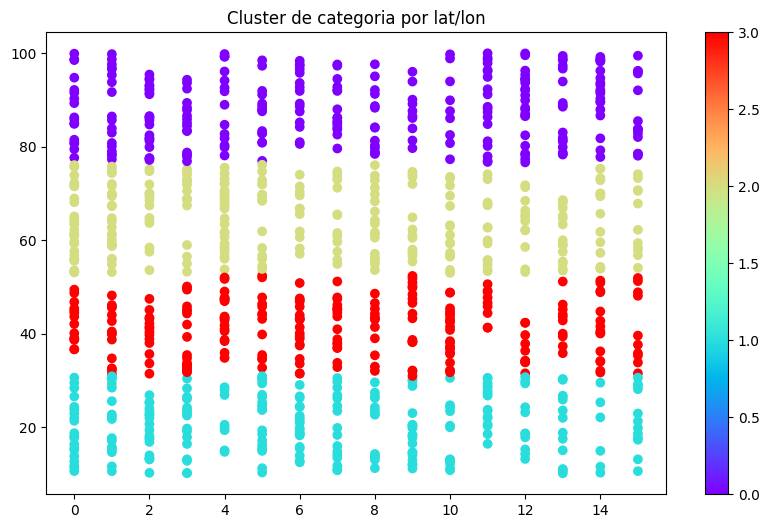

In [110]:
# 4. Visualização dos Clusters

# Convertendo colunas para listas para plotagem
value = [float(row['value']) for row in predictions.select('value').collect()]
categoryIndex = [float(row['categoryIndex']) for row in predictions.select('categoryIndex').collect()]
clusters = [int(row['prediction']) for row in predictions.select('prediction').collect()]

# Cluster de categoria por lat/lon
plt.figure(figsize=(10,6))
plt.scatter(categoryIndex, value, c=clusters, cmap='rainbow')
plt.title("Cluster de categoria por lat/lon")
plt.colorbar()
plt.show()

In [115]:
import folium
import folium

# Crie um mapa centrado em uma localização média
pandas_df = predictions.select(f.col("lat").cast("float"), f.col("lon").cast("float"), "prediction").filter(f.col("prediction").isin([3, 0])).toPandas()
map_center = [pandas_df['lat'].mean(), pandas_df['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=4)

# Adicione marcadores para cada ponto
for _, row in pandas_df.iterrows():
    if row['prediction'] == 3:
        color = 'red'
    elif row['prediction'] == 0:
        color = 'blue'
        
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color
    ).add_to(m)
m

In [113]:
# TODO Printar os cpfs do cluster 3 que representa os clientes com maior gasto



<Figure size 1200x600 with 0 Axes>

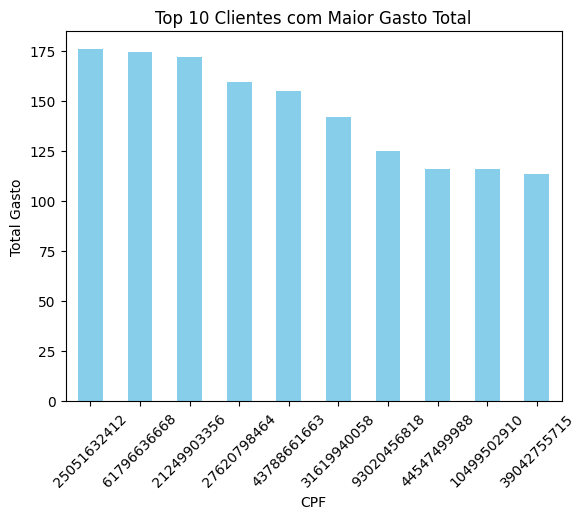

In [99]:
import matplotlib.pyplot as plt

# Análise
total_spent_per_customer = df.groupBy("cpf").agg(f.sum("value").alias("total_spent")).orderBy(f.desc("total_spent")).withColumn("total_spent", f.col("total_spent").cast("float")).toPandas()

# Plotagem
plt.figure(figsize=(12, 6))
total_spent_per_customer.head(10).plot(x='cpf', y='total_spent', kind='bar', legend=False, color='skyblue')
plt.title('Top 10 Clientes com Maior Gasto Total')
plt.ylabel('Total Gasto')
plt.xlabel('CPF')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x600 with 0 Axes>

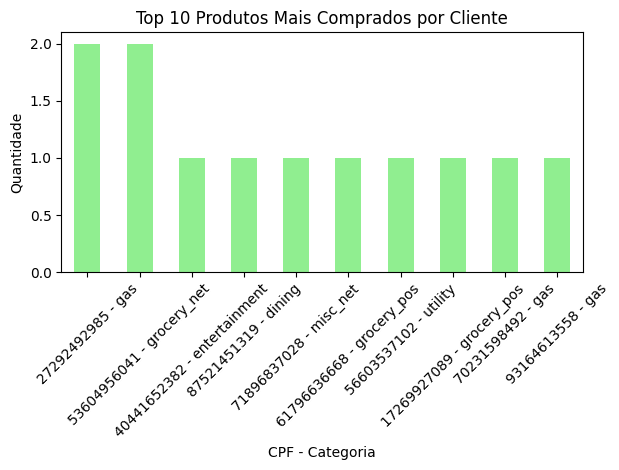

In [101]:
top_products_per_customer = df.groupBy("cpf", "category").count().orderBy(f.desc("count")).toPandas()
top_products_per_customer['cpf_category'] = top_products_per_customer['cpf'].astype(str) + ' - ' + top_products_per_customer['category']

# Plot
plt.figure(figsize=(12, 6))
top_products_per_customer.head(10).plot(x='cpf_category', y='count', kind='bar', legend=False, color='lightgreen')
plt.title('Top 10 Produtos Mais Comprados por Cliente')
plt.ylabel('Quantidade')
plt.xlabel('CPF - Categoria')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

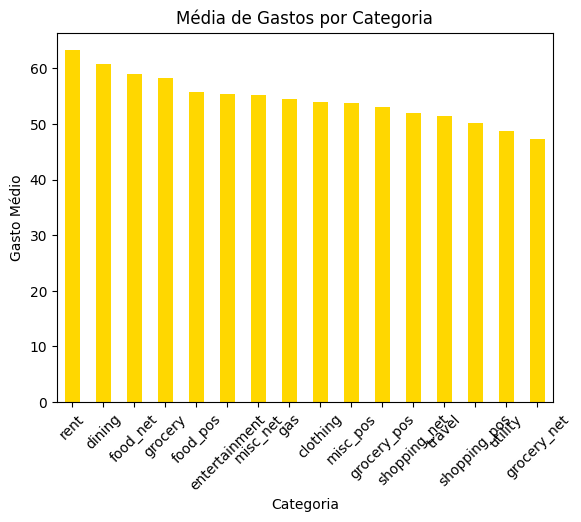

In [103]:
# Análise
avg_spent_per_category = df.groupBy("category").agg(f.avg("value").alias("avg_spent")).orderBy(f.desc("avg_spent")).withColumn("avg_spent", f.col("avg_spent").cast("float")).toPandas()

# Plotagem
plt.figure(figsize=(12, 6))
avg_spent_per_category.plot(x='category', y='avg_spent', kind='bar', legend=False, color='gold')
plt.title('Média de Gastos por Categoria')
plt.ylabel('Gasto Médio')
plt.xlabel('Categoria')
plt.xticks(rotation=45)
plt.show()


<Figure size 1200x600 with 0 Axes>

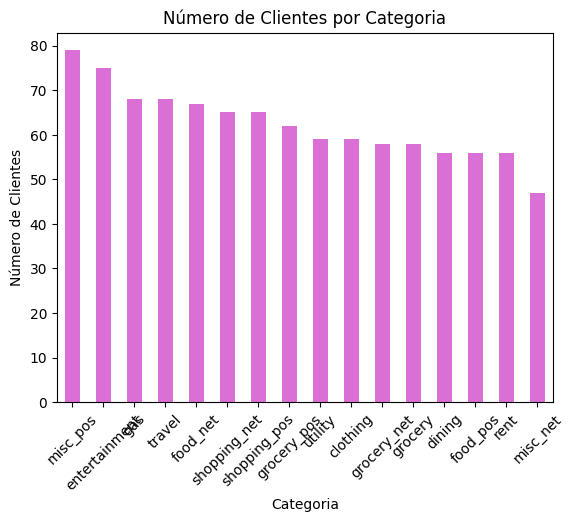

In [105]:
# Análise
customers_per_category = df.groupBy("category").agg(f.countDistinct("cpf").alias("num_customers")).orderBy(f.desc("num_customers")).withColumn("num_customers", f.col("num_customers").cast("float")).toPandas()

# Plotagem
plt.figure(figsize=(12, 6))
customers_per_category.plot(x='category', y='num_customers', kind='bar', legend=False, color='orchid')
plt.title('Número de Clientes por Categoria')
plt.ylabel('Número de Clientes')
plt.xlabel('Categoria')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x600 with 0 Axes>

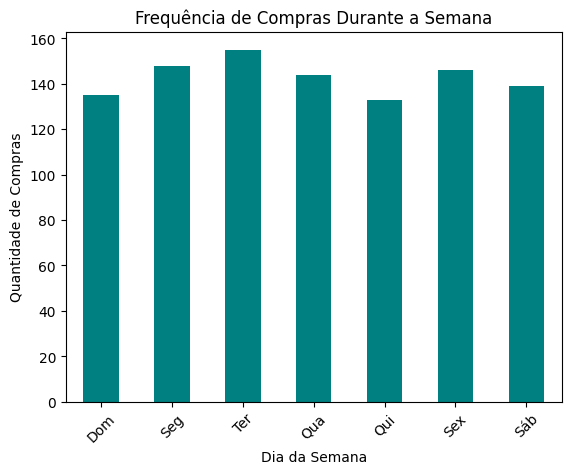

In [106]:
# Análise
purchases_per_weekday = df.withColumn("day_of_week", f.dayofweek("trans_date")).groupBy("day_of_week").count().orderBy("day_of_week").toPandas()

# Plotagem
days = ["Dom", "Seg", "Ter", "Qua", "Qui", "Sex", "Sáb"]
plt.figure(figsize=(12, 6))
purchases_per_weekday.plot(x='day_of_week', y='count', kind='bar', legend=False, color='teal')
plt.title('Frequência de Compras Durante a Semana')
plt.ylabel('Quantidade de Compras')
plt.xlabel('Dia da Semana')
plt.xticks(ticks=purchases_per_weekday.index, labels=days, rotation=45)
plt.show()